In [1]:
%pip install -U statsmodels scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
from itertools import combinations

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

In [3]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

# Chapter 06

This chapter formalizes the concept of $d$-separation and introduces the concept of estimand. We learn how $d$-separation in a graph translates to regression analysis. Next, we focus on estimands. We define basic yet powerful estimands: back-door and front-door criteria. Next, we introduce other criteria and the concept of Pearl’s $do$-calculus. Finally, we translate our new knowledge into Python code and perform a couple of exercises to solidify our new knowledge.

## Visualizations

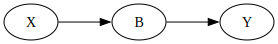

In [6]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'B', 'Y']
positions = ['1,0!', '2.5,0!', '4,0!']

edges = ['XB', 'BY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_06_d_sep_00')

graph

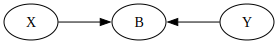

In [7]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'B', 'Y']
positions = ['1,0!', '2.5,0!', '4,0!']

edges = ['XB', 'YB']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_06_d_sep_01')

graph

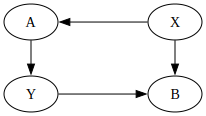

In [8]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['A', 'X', 'B', 'Y']
positions = ['1,1!', '3,1!', '3,0!', '1, 0!']

edges = ['XB', 'YB', 'XA', 'AY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_06_d_sep_02')

graph

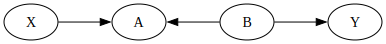

In [9]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['A', 'X', 'B', 'Y']
positions = ['1.5,0!', '0,0!', '3,0!', '4.5,0!']

edges = ['XA', 'BA', 'BY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_06_d_sep_03')

graph

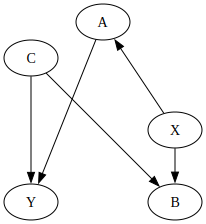

In [10]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['A', 'X', 'B', 'Y', 'C']
positions = ['2,2.5!', '3,1!', '3,0!', '1, 0!', '1,2!']

edges = ['XA', 'XB', 'CB', 'CY', 'AY']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(f'img/ch_06_d_sep_04')

graph

## Estimand first!

In [11]:
# Commute example
t = [22.1, 23.7, 25.2, 20.0, 21.8]

In [12]:
np.mean(t)

np.float64(22.56)

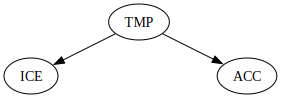

In [13]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['ICE', 'TMP', 'ACC']
positions = ['0,0!', '1.5,.75!', '3,0!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edge('TMP', 'ICE')
graph.edge('TMP', 'ACC')

graph.render(f'img/ch_06_icecream')

graph

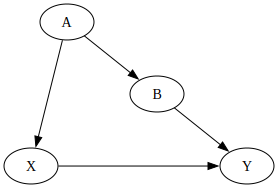

In [14]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'Y', 'A', 'B']
positions = ['0,0!', '3,0!', '.5,2!', '1.75,1!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(['XY', 'AX', 'AB', 'BY'])

graph.render(f'img/ch_06_equivalent_estimands_00')

graph

In [17]:
#?graph.edge

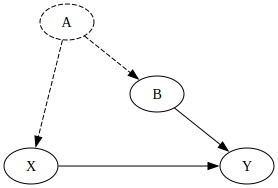

In [18]:
graph = graphviz.Digraph(format='png', engine='neato')


nodes = ['X', 'Y', 'A', 'B']
positions = ['0,0!', '3,0!', '.5,2!', '1.75,1!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('A', style='dashed')

graph.edges(['XY', 'BY'])
graph.edge('A', 'X', style='dashed')
graph.edge('A', 'B', style='dashed')

graph.render(f'img/ch_06_equivalent_estimands_01')

graph

## Front-door criterion

In [20]:
%pip install dowhy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.4 MB/s  0:00:007.3 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 7.5 MB/s  0:00:02a 0:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.1/935.1 kB 4.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 4.8 MB/s  0:00:00a 0:00:01m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.1 MB/s  0:00:009.4 MB/s eta 0:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.17.0
    Uninstalling scipy-1.17.0:
      Successfully uninstalled scipy-1.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [dowhy]━━━ 10/11 [dowhy][causal-learn]
Note: you may need to restart the kernel to use updated packages.


In [22]:
from dowhy.causal_model import CausalModel

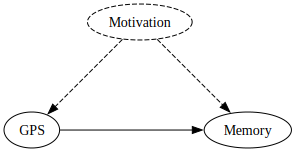

In [23]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['GPS', 'Memory', 'Motivation']
positions = ['0,0!', '3,0!', '1.5,1.5!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('Motivation', style='dashed')

graph.edge('Motivation', 'GPS', style='dashed')
graph.edge('Motivation', 'Memory', style='dashed')
graph.edge('GPS', 'Memory')

graph.render(f'img/ch_06_gps_01')

graph

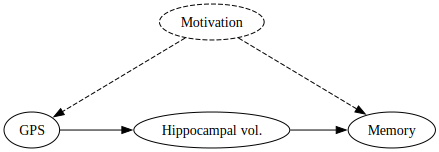

In [24]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['GPS', 'Hippocampal vol.', 'Memory', 'Motivation']
positions = ['0,0!', '2.5,0!', '5,0!', '2.5,1.5!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('Motivation', style='dashed')

graph.edge('Motivation', 'GPS', style='dashed')
graph.edge('Motivation', 'Memory', style='dashed')
graph.edge('GPS', 'Hippocampal vol.')
graph.edge('Hippocampal vol.', 'Memory')

graph.render(f'img/ch_06_gps_02')

graph

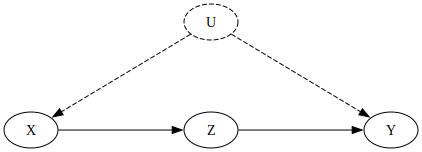

In [25]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'Z', 'Y', 'U']
positions = ['0,0!', '2.5,0!', '5,0!', '2.5,1.5!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('U', style='dashed')

graph.edge('U', 'X', style='dashed')
graph.edge('U', 'Y', style='dashed')
graph.edge('X', 'Z')
graph.edge('Z', 'Y')

graph.render(f'img/ch_06_gps_03')

graph

### Front-door in practice

In [26]:
from sklearn.linear_model import LinearRegression

In [29]:
# First, we'll build a structural causal model (SCM)
class GPSMemorySCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.inf, scale=5)
        self.u_y = stats.norm(scale=2)
        self.u_z = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.inf, scale=4)
        
    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        u = self.u.rvs(sample_size)
        
        if treatment_value:
            gps = np.array([treatment_value]*sample_size)
        else:
            gps = u_x + 0.7*u
            
        hippocampus = -0.6*gps + 0.25*u_z
        memory = 0.7*hippocampus + 0.25*u
        
        return gps, hippocampus, memory
    
    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [30]:
# Instantiate the SCM
scm = GPSMemorySCM()

# Generate observational data
gps_obs, hippocampus_obs, memory_obs = scm.sample(600)

# Run an experiment
treatments = []
experiment_results = []

# Sample over various treatments
for treatment in np.arange(1, 21):
    gps_hours, hippocampus, memory = scm.intervene(treatment_value=treatment, sample_size=30)
    experiment_results.append(memory)
    treatments.append(gps_hours)

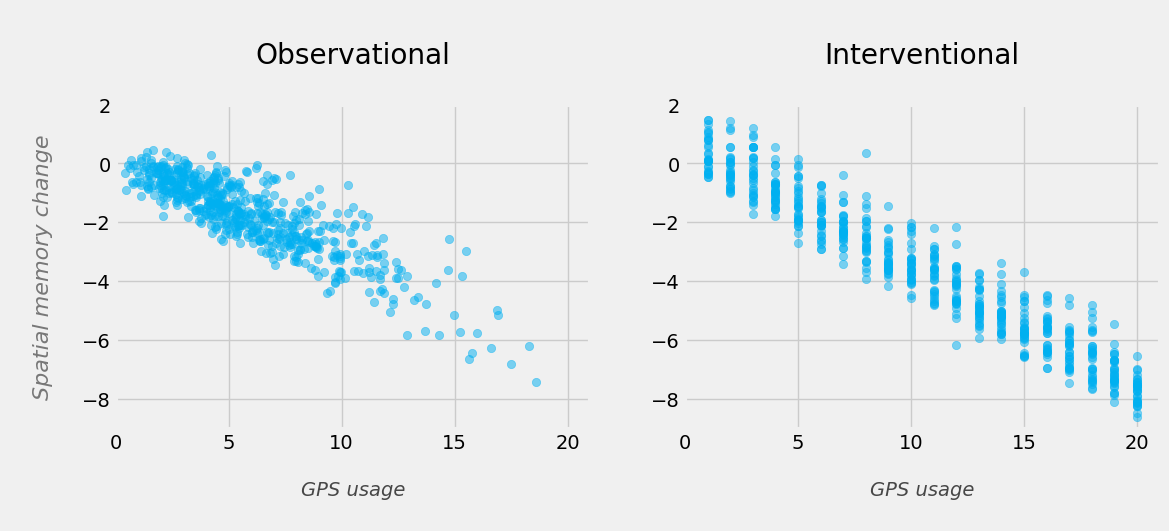

In [31]:
# Plot observational data
plt.figure(figsize=(12, 4))

# Observational
plt.subplot(121)
plt.scatter(gps_obs, memory_obs, alpha=.5, color=COLORS[0])
plt.xlim(0, 21)
plt.ylim(-9, 2)

plt.title('\nObservational\n')
plt.xlabel('\nGPS usage', alpha=.7, fontsize=14, style='italic')
plt.ylabel('\nSpatial memory change\n', alpha=.5, fontsize=16, style='italic')


# Interventional
plt.subplot(122)

plt.scatter(treatments, experiment_results, alpha=.5, color=COLORS[0])
plt.xlim(0, 21)
plt.ylim(-9, 2)

plt.title('\nInterventional\n')
plt.xlabel('\nGPS usage\n', alpha=.7, fontsize=14, style='italic')

plt.show()

### Naive model 1

In [33]:
lr_naive = LinearRegression()
lr_naive.fit(
    X=gps_obs.reshape(-1, 1), 
    y=memory_obs
)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


### Experimental model

In [34]:
treatments_unpack = np.array(treatments).flatten()
results_unpack = np.array(experiment_results).flatten()

lr_experiment = LinearRegression()
lr_experiment.fit(
    X=treatments_unpack.reshape(-1, 1), 
    y=results_unpack
)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [35]:
X_test = np.arange(1, 21).reshape(-1, 1)

preds_naive = lr_naive.predict(X_test) 
preds_experiment = lr_experiment.predict(X_test)

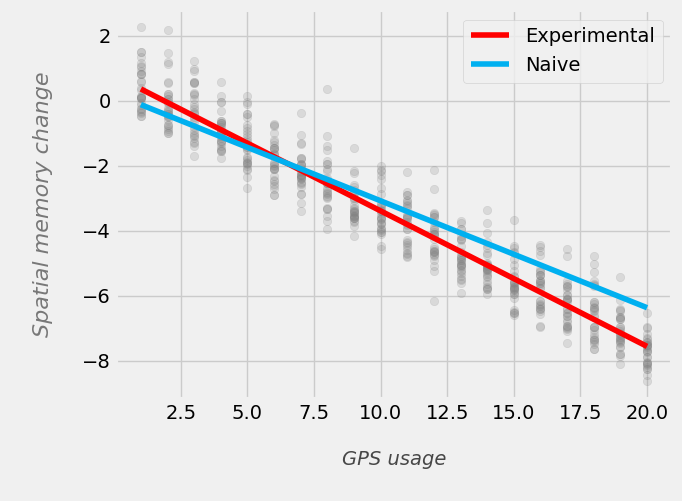

In [36]:
plt.scatter(treatments, experiment_results, alpha=.2, color='gray')
plt.plot(X_test, preds_experiment, label='Experimental', color=COLORS[1])
plt.plot(X_test, preds_naive, label='Naive', color=COLORS[0])

plt.xlabel('\nGPS usage\n', alpha=.7, fontsize=14, style='italic')
plt.ylabel('\nSpatial memory change\n', alpha=.5, fontsize=16, style='italic')

plt.legend()
plt.show()

In [37]:
# Get coefficients
print(f'Naive model:\n{lr_naive.coef_[0]}\n')
print(f'Experiemntal model:\n{lr_experiment.coef_[0]}')

Naive model:
-0.3286801957861329

Experiemntal model:
-0.41659408196330827


#### The Linear Bridge to The Causal Promised Land

In [38]:
from dowhy.causal_model import CausalModel
from sklearn.linear_model import LinearRegression

In [39]:
# Model E(Z|X)
lr_zx = LinearRegression()
lr_zx.fit(
    X=gps_obs.reshape(-1, 1),
    y=hippocampus_obs
)

# Model E(Y|X, Z)E(X)
lr_yxz = LinearRegression()
lr_yxz.fit(
    X=np.array([gps_obs,hippocampus_obs]).T,
    y=memory_obs
)

# Compute the expected causal effect
lr_zx.coef_[0] * lr_yxz.coef_[1]

### Instrumental variables

**NOTE**: In the book (p. 121) one of the formulas for regression models is <font color='red'>**incorrect**</font>. 

The book says:

_________


*To calculate the causal effect of X on Y in a linear case, all we need to do is fit two linear regression
models and compute the ratio of their coefficients!*

*The two models are as follows:*

*• Y ~ Z*

<font color='red'>*• Y ~ X*</font>

_____________


The <font color='green'>**correct**</font> formulas should be:

_____________

*The two models are as follows:*

*• Y ~ Z*

<font color='green'>*• X ~ Z*</font>

__________________


The **code example** below uses the <font color='green'>**correct formulas**</font>.

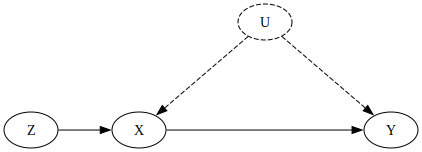

In [40]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['Z', 'X', 'Y', 'U']
positions = ['0,0!', '1.5,0!', '5,0!', '3.25,1.5!']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]

# Overwrite style
graph.node('U', style='dashed')

graph.edge('U', 'X', style='dashed')
graph.edge('U', 'Y', style='dashed')
graph.edge('Z', 'X')
graph.edge('X', 'Y')

graph.render(f'img/ch_06_instrumental_00')

graph

In [41]:
# First, we'll build a structural causal model (SCM)
class InsrumentalSCM:
    
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_xy = stats.norm()
        self.u_z = stats.norm()
        
    def sample(self, sample_size=100):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)
        
        u_xy = self.u_xy.rvs(sample_size)
        u_z = self.u_z.rvs(sample_size)
        
        z = u_z
        x = 0.7*z + 0.2*u_xy
        y = 0.8*x + 0.1*u_xy
        
        return z, x, y

In [42]:
# Instantiate the SCM and sample
instr_scm = InsrumentalSCM()
z, x, y = instr_scm.sample(1000)

In [43]:
# Fit regression 1
lr_yz = LinearRegression()
lr_yz.fit(X=z.reshape(-1, 1), y=y)

# Fit regression 2
lr_xz = LinearRegression()
lr_xz.fit(X=z.reshape(-1, 1), y=x)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [44]:
# Compute the causal effect
causal_effect = lr_yz.coef_[0] / lr_xz.coef_[0]
causal_effect

In [45]:
# Sanity check
random_z = np.random.randn()

random_z * .7 * .8, random_z * .7 * causal_effect

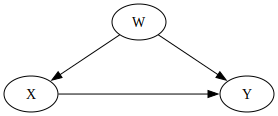

In [46]:
graph = graphviz.Digraph(format='png', engine='neato')

nodes = ['X', 'W', 'Y']
positions = ['1,0!', '2.5,1!', '4,0!']

edges = ['XY', 'WY', 'WX']

[graph.node(n, pos=pos) for n, pos in zip(nodes, positions)]
graph.edges(edges)

graph.render(r'C:\Users\aleks\OneDrive\Pulpit\BCKDR.png')

graph